In [1]:
# main libraries for data processing/plotting
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import seaborn as sns

# import torch functionality
import torch
from torch.utils.data import DataLoader, TensorDataset

# import flower modules
import flwr as fl
from flwr.server.strategy import FedAvg

# import custom modules
from fedtabdiff_modules import init_model
from FlowerClient import get_client_fn, get_eval_config
from FlowerServer import get_evaluate_server_fn
from utils import get_parameters

%load_ext autoreload
%autoreload 2

Set parameters and seed

In [2]:
# define global experiment parameters
exp_params = dict(

    seed = 111, # random seed
    batch_size = 512, # batch size   
    n_cat_emb = 2, # size of the categorical embeddings (2 means each attribute will be 2-dimensional)
    learning_rate = 1e-4, # learning rate

    mlp_layers = [512, 512], # total neurons at each hidden feed-forward layer
    activation = 'lrelu', # activation function

    # diffusion parameters
    diffusion_steps = 500,  # number of diffusion steps
    diffusion_beta_start = 1e-4, # initial value of beta
    diffusion_beta_end = 0.02, # final value of beta
    scheduler = 'linear', # linear or quad

    # federated parameters
    server_rounds = 100, # number of server rounds
    client_rounds = 5, # number of client rounds
    n_clients = 5, # number of clients
    fraction_fit = 1.0, # fraction of clients used for training
    fraction_evaluate=1.0, # fraction of clients used for evaluation
    min_fit_clients=5, # minimum number of clients used for training
    min_evaluate_clients=1, # minimum number of clients used for evaluation

    # evaluation periods
    eval_rate_server = 10, # evaluate server every n rounds
    eval_rate_client = 100, # evaluate client every n rounds

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
)
    
# set seed
rng = np.random.default_rng(exp_params['seed']) # set numpy seed
torch.manual_seed(exp_params['seed'])  # set pytorch seed CPU
torch.cuda.manual_seed(exp_params['seed'])  # set pytorch seed GPU

# Load and preprocess dataset
The City of Philadelphia Payments is used for showing the technique. The dataset can be accessed under the following link: https://www.phila.gov/2019-03-29-philadelphias-initial-release-of-city-payments-data 

In [3]:
# read csv file
train_raw = pd.read_csv(r'data/city_payments_fy2017.csv.zip')

# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', ' ') for col in train_raw.columns]

# identify numeric and categorical attributes
cat_attrs = ['fm', 'check date', 'department title', 'character title', 'sub obj title', 'vendor name', 'contract description']
num_attrs = ['transaction amount']

# extract label
label_name = 'doc ref no prefix definition'
label = train_raw[label_name]

# take subset of top 5 most frequent label values
top_n = train_raw[label_name].value_counts().nlargest(5).index
train_raw = train_raw[train_raw[label_name].isin(top_n)].reset_index(drop=True)

# add col name to every entry to make them distinguishable for embedding
for cat_attr in cat_attrs:
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

# extract and transform label
label = train_raw[label_name].fillna('NA')
class_encoder = LabelEncoder().fit(label)
label = class_encoder.transform(label)

In [4]:
# take cat and num subsets
train = train_raw[[*cat_attrs, *num_attrs]]

# update categorical attributes
train[cat_attrs] = train[cat_attrs].astype(str)

print('Processed data: Train shape: {}'.format(train.shape))

Processed data: Train shape: (215302, 8)


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_5688/862577455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_attrs] = train[cat_attrs].astype(str)


In [5]:
### transform numeric attributes
num_scaler = QuantileTransformer(output_distribution='normal', random_state=exp_params['seed'])
num_scaler.fit(train[num_attrs])
train_num_scaled = num_scaler.transform(train[num_attrs])

### transform categorical attributes
# get unique vocabulary values
vocabulary_classes = np.unique(train[cat_attrs])
# fit label encoder
label_encoder = LabelEncoder().fit(vocabulary_classes)
# transform dataset
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)
# collect unique categories of each attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

# add processed data parameters to experiment parameters
exp_params['n_cat_tokens'] = len(vocabulary_classes)
exp_params['n_classes'] = len(np.unique(label))
exp_params['cat_dim'] = exp_params['n_cat_emb'] * len(cat_attrs)
exp_params['encoded_dim'] = exp_params['cat_dim'] + len(num_attrs)
exp_params['vocab_per_attr'] = vocab_per_attr
exp_params['num_scaler'] = num_scaler
exp_params['num_attrs'] = num_attrs
exp_params['cat_attrs'] = cat_attrs
exp_params['label_encoder'] = label_encoder

# init torch tensors
train_num_torch = torch.FloatTensor(train_num_scaled)
train_cat_torch = torch.LongTensor(train_cat_scaled.values)
label_torch = torch.LongTensor(label)

print('Encoded categorical data: Train shape: {}'.format(train_cat_torch.shape))
print('Encoded numerical data: Train shape: {}'.format(train_num_torch.shape))

Encoded categorical data: Train shape: torch.Size([215302, 7])
Encoded numerical data: Train shape: torch.Size([215302, 1])


### Split preprocessed dataset into train and test data loaders. In addition, every data loader contains multiple non-overlaping data partitions. The data is partitioned according to a selected label. Each partition will be assigned to individual client during training. Such scheme simulates the non-iid data split.

In [6]:
# collect list of indices based on label (non-iid splits)
unique_keys = np.unique(label)
data_split_mapping = {k: np.argwhere(label == k).squeeze() for k in unique_keys}

# split train, test and label sets
train_loaders_client = []
test_loaders_client = []
test_loader_server = (train, label_torch) # here the complete train set is used to evaluate on the entire population distribution

for indices in data_split_mapping.values():

    # pack train partitiones into TensorDataset
    train_set = TensorDataset(
        train_cat_torch[indices],        
        train_num_torch[indices],
        label_torch[indices]
        )

    # pack test partitiones 
    test_set = (
       train.iloc[indices], 
       label_torch[indices]
    )

    # append train and test loaders
    train_loaders_client.append(DataLoader(train_set, batch_size=exp_params['batch_size'], shuffle=True))
    test_loaders_client.append(test_set)

# Initialize synthesizer (FinDiff) and flower client/server functions

In [7]:
# init synthesizer and diffuser
synthesizer, diffuser = init_model(exp_params=exp_params)

# Get the initialized model parameters
init_params = get_parameters(synthesizer)

# define client function. It will be called by the VirtualClientEngine whenever a client is sampled by the strategy to participate.
client_fn = get_client_fn(
    train_loaders=train_loaders_client,
    test_loaders=test_loaders_client,
    exp_params=exp_params
)

# define server function for evaluation of entire population. It will be called at every training round.
evaluate_server_fn = get_evaluate_server_fn(
    test_loader=test_loader_server,
    exp_params=exp_params
)

# function used to configure training. We use it to append global experiment parameters to the training config. 
evaluate_client_fn = get_eval_config(exp_params=exp_params)

# init strategy parameters
strategy_params = dict(
    fraction_fit=exp_params['fraction_fit'],
    fraction_evaluate=exp_params['fraction_evaluate'],
    min_fit_clients=exp_params['min_fit_clients'],
    min_evaluate_clients=exp_params['min_evaluate_clients'],
    min_available_clients=exp_params['n_clients'],
    initial_parameters=fl.common.ndarrays_to_parameters(init_params),
    evaluate_fn=evaluate_server_fn,
    on_fit_config_fn=evaluate_client_fn,
    on_evaluate_config_fn=evaluate_client_fn
)
strategy = FedAvg(**strategy_params) # FedAvg is the default strategy

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if exp_params['device'] == 'cuda':
    client_resources = {"num_gpus": 1, "num_cpus": 4}


Initializing FedTabDiff model


In [8]:
# Start simulation
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=exp_params['n_clients'],
    config=fl.server.ServerConfig(num_rounds=exp_params['server_rounds']),
    strategy=strategy,
    client_resources=client_resources
)

INFO flwr 2024-01-25 17:35:44,770 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2024-01-25 17:35:46,900	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-25 17:35:48,092 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7191229236.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2024-01-25 17:35:48,092 | server.py:86 | Initializing global parameters
INFO flwr 2024-01-25 17:35:48,092 | server.py:269 | Using initial parameters provided by strategy
INFO flwr 2024-01-25 17:35:48,093 | server.py:88 | Evaluating initial parameters
INFO flwr 2024-01-25 17:35:48,098 | server.py:101 | FL starting
DEBUG flwr 2024-01-25 17:35:48,098 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:35:52,468 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-01-25 17:35:52,481 | f

(launch_and_fit pid=5749) Initializing FedTabDiff model
(launch_and_fit pid=5749) [Client 4] fit, n_samples: 36793


DEBUG flwr 2024-01-25 17:35:54,406 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-01-25 17:35:54,406 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-01-25 17:35:54,406 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5751) Client-side fidelity None


DEBUG flwr 2024-01-25 17:35:56,275 | server.py:232 | fit_round 2 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:35:56,287 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:35:58,100 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:35:58,100 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5745) Initializing FedTabDiff model [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(launch_and_fit pid=5750) [Client 3] fit, n_samples: 93119 [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:35:59,949 | server.py:232 | fit_round 3 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:35:59,961 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:36:01,727 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:01,728 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:36:03,605 | server.py:232 | fit_round 4 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:03,618 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5749) [Client 0] fit, n_samples: 40038 [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:36:05,369 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:05,369 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5751) Client-side fidelity None [repeated 5x across cluster]


DEBUG flwr 2024-01-25 17:36:07,235 | server.py:232 | fit_round 5 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:07,247 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:36:09,004 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:09,005 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 4] fit, n_samples: 36793 [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:36:10,849 | server.py:232 | fit_round 6 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:10,862 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 10x across cluster]


DEBUG flwr 2024-01-25 17:36:12,598 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:12,598 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:36:14,420 | server.py:232 | fit_round 7 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:14,433 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


(launch_and_fit pid=5744) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5744) [Client 4] fit, n_samples: 36793 [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:36:16,193 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:16,193 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:36:18,039 | server.py:232 | fit_round 8 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:18,052 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:36:19,935 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:19,936 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 1] fit, n_samples: 28521 [repeated 9x across cluster]
(launch_and_evaluate pid=5745) Client-side fidelity None [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:36:21,866 | server.py:232 | fit_round 9 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:21,880 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:36:23,640 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:36:23,641 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:36:25,526 | server.py:232 | fit_round 10 received 5 results and 0 failures


(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5749) [Client 1] fit, n_samples: 28521 [repeated 6x across cluster]
Initializing FedTabDiff model
[Server evaluation, server round: 10
Loading eval set


SAMPLING STEP:    0: : 500it [04:03,  2.06it/s]
/Users/timur/Documents/Projects/24_Federated_Table_Diffusion/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
INFO flwr 2024-01-25 17:40:53,392 | server.py:119 | fit progress: (10, None, {'fidelity': 0.1595026985350748}, 305.298049791)
DEBUG flwr 2024-01-25 17:40:53,393 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


Server-side fidelity 0.1595026985350748


DEBUG flwr 2024-01-25 17:40:55,409 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:40:55,410 | server.py:218 | fit_round 11: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 5x across cluster]
(launch_and_fit pid=5750) [Client 3] fit, n_samples: 93119 [repeated 4x across cluster]


DEBUG flwr 2024-01-25 17:40:57,344 | server.py:232 | fit_round 11 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:40:57,357 | server.py:168 | evaluate_round 11: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:40:59,375 | server.py:182 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:40:59,376 | server.py:218 | fit_round 12: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 9x across cluster]
(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5749) [Client 3] fit, n_samples: 93119 [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:41:01,498 | server.py:232 | fit_round 12 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:01,511 | server.py:168 | evaluate_round 12: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:03,499 | server.py:182 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:03,499 | server.py:218 | fit_round 13: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:05,478 | server.py:232 | fit_round 13 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:05,493 | server.py:168 | evaluate_round 13: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:07,396 | server.py:182 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:07,396 | server.py:218 | fit_round 14: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 1] fit, n_samples: 28521 [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:41:09,262 | server.py:232 | fit_round 14 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:09,275 | server.py:168 | evaluate_round 14: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:11,075 | server.py:182 | evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:11,076 | server.py:218 | fit_round 15: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:12,914 | server.py:232 | fit_round 15 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:12,926 | server.py:168 | evaluate_round 15: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 9x across cluster]
(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5749) [Client 3] fit, n_samples: 93119 [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:41:14,666 | server.py:182 | evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:14,666 | server.py:218 | fit_round 16: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:16,494 | server.py:232 | fit_round 16 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:16,508 | server.py:168 | evaluate_round 16: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:18,334 | server.py:182 | evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:18,335 | server.py:218 | fit_round 17: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5744) Client-side fidelity None [repeated 5x across cluster]
(launch_and_evaluate pid=5751) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 1] fit, n_samples: 28521 [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:41:20,167 | server.py:232 | fit_round 17 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:20,181 | server.py:168 | evaluate_round 17: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:21,958 | server.py:182 | evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:21,959 | server.py:218 | fit_round 18: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:23,811 | server.py:232 | fit_round 18 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:23,823 | server.py:168 | evaluate_round 18: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 10x across cluster]
(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5749) [Client 4] fit, n_samples: 36793 [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:41:25,576 | server.py:182 | evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:25,576 | server.py:218 | fit_round 19: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:27,428 | server.py:232 | fit_round 19 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:27,440 | server.py:168 | evaluate_round 19: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:41:29,191 | server.py:182 | evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:41:29,191 | server.py:218 | fit_round 20: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 4] fit, n_samples: 36793 [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:41:31,005 | server.py:232 | fit_round 20 received 5 results and 0 failures


Initializing FedTabDiff model
[Server evaluation, server round: 20
Loading eval set


SAMPLING STEP:    0: : 500it [03:53,  2.14it/s]
/Users/timur/Documents/Projects/24_Federated_Table_Diffusion/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
INFO flwr 2024-01-25 17:45:47,949 | server.py:119 | fit progress: (20, None, {'fidelity': 0.15250671150290596}, 599.841802625)
DEBUG flwr 2024-01-25 17:45:47,950 | server.py:168 | evaluate_round 20: strategy sampled 5 clients (out of 5)


Server-side fidelity 0.15250671150290596


DEBUG flwr 2024-01-25 17:45:49,894 | server.py:182 | evaluate_round 20 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:45:49,895 | server.py:218 | fit_round 21: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 5x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 10x across cluster]
(launch_and_fit pid=5745) [Client 1] fit, n_samples: 28521 [repeated 5x across cluster]


DEBUG flwr 2024-01-25 17:45:51,744 | server.py:232 | fit_round 21 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:45:51,757 | server.py:168 | evaluate_round 21: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:45:53,549 | server.py:182 | evaluate_round 21 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:45:53,550 | server.py:218 | fit_round 22: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:45:55,433 | server.py:232 | fit_round 22 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:45:55,448 | server.py:168 | evaluate_round 22: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 9x across cluster]
(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 4] fit, n_samples: 36793 [repeated 5x across cluster]


DEBUG flwr 2024-01-25 17:45:57,230 | server.py:182 | evaluate_round 22 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:45:57,230 | server.py:218 | fit_round 23: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:45:59,091 | server.py:232 | fit_round 23 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:45:59,105 | server.py:168 | evaluate_round 23: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:00,905 | server.py:182 | evaluate_round 23 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:00,905 | server.py:218 | fit_round 24: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 0] fit, n_samples: 40038 [repeated 10x across cluster]


DEBUG flwr 2024-01-25 17:46:02,935 | server.py:232 | fit_round 24 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:02,948 | server.py:168 | evaluate_round 24: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:04,773 | server.py:182 | evaluate_round 24 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:04,774 | server.py:218 | fit_round 25: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:06,685 | server.py:232 | fit_round 25 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:06,697 | server.py:168 | evaluate_round 25: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 9x across cluster]
(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5749) [Client 2] fit, n_samples: 16831 [repeated 6x across cluster]


DEBUG flwr 2024-01-25 17:46:08,471 | server.py:182 | evaluate_round 25 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:08,471 | server.py:218 | fit_round 26: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:10,290 | server.py:232 | fit_round 26 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:10,302 | server.py:168 | evaluate_round 26: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:12,057 | server.py:182 | evaluate_round 26 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:12,058 | server.py:218 | fit_round 27: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5751) [Client 1] fit, n_samples: 28521 [repeated 9x across cluster]


DEBUG flwr 2024-01-25 17:46:13,896 | server.py:232 | fit_round 27 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:13,909 | server.py:168 | evaluate_round 27: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:15,662 | server.py:182 | evaluate_round 27 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:15,662 | server.py:218 | fit_round 28: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:17,506 | server.py:232 | fit_round 28 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:17,521 | server.py:168 | evaluate_round 28: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5750) Client-side fidelity None [repeated 9x across cluster]
(launch_and_fit pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 2] fit, n_samples: 16831 [repeated 5x across cluster]


DEBUG flwr 2024-01-25 17:46:19,277 | server.py:182 | evaluate_round 28 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:19,278 | server.py:218 | fit_round 29: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:21,134 | server.py:232 | fit_round 29 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:21,147 | server.py:168 | evaluate_round 29: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-01-25 17:46:22,915 | server.py:182 | evaluate_round 29 received 5 results and 0 failures
DEBUG flwr 2024-01-25 17:46:22,916 | server.py:218 | fit_round 30: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=5749) Client-side fidelity None [repeated 6x across cluster]
(launch_and_evaluate pid=5749) Initializing FedTabDiff model [repeated 15x across cluster]
(launch_and_fit pid=5750) [Client 3] fit, n_samples: 93119 [repeated 10x across cluster]


DEBUG flwr 2024-01-25 17:46:24,745 | server.py:232 | fit_round 30 received 5 results and 0 failures


Initializing FedTabDiff model
[Server evaluation, server round: 30
Loading eval set


SAMPLING STEP:  316: : 183it [01:25,  2.12it/s]

(launch_and_evaluate pid=4846) Client-side fidelity 0.472268016545334


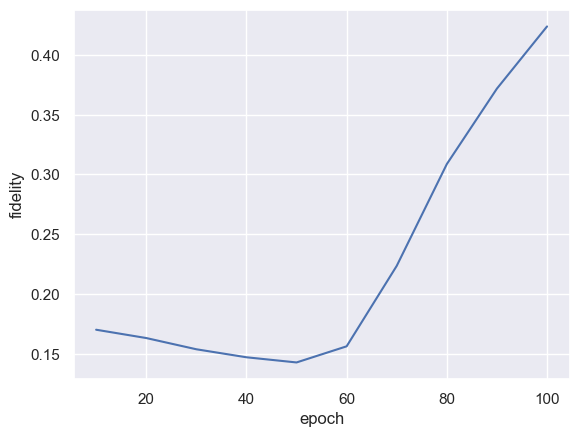

In [ ]:
# plot fidelity scores
sns.set_theme(style="darkgrid")
plot_df = pd.DataFrame(hist.metrics_centralized['fidelity'], 
                       columns=['epoch', 'fidelity'])
sns.lineplot(data=plot_df, x='epoch', y='fidelity');